
# Modelling Seasonality in Candy Production with SARIMAX


In [6]:
import math
import itertools
import pandas as pd
import numpy as np
from scipy.stats import boxcox, kurtosis, skew
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight') 
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

%matplotlib inline

In [7]:
df = pd.read_csv('candy_production.csv')
df = df.rename(columns={'observation_date': 'date', 'IPG3113N':'production'})
df.index = pd.DatetimeIndex(data= df.date)
df = df.drop(columns=['date'])
df.head()

,production
date,
1972-01-01,85.6945
1972-02-01,71.8200
1972-03-01,66.0229
1972-04-01,64.5645
1972-05-01,65.0100


# SARIMA
---
## Seasonality (S)
In our last kernel() we broke down the various parts of an ARIMA model. Now, we introduce *seasonality* with the addition of *S* in SARIMA. Seasonality is a common feature and deterministic source of non-stationarity that we have to account for in real life data. Where our ARIMA model had only three parameters to deal with, modelling seasonality will require 4 parameters by itself. 

They are: 
1. P: Seasonal Autoregressive order
2. D: Seasonal difference order
3. Q: Seasonal moving average order
4. m: The number of time steps for a single seasonal period. 

Specified as $SARIMA(p,d,q)(P,D,Q)[m]$

To determine the parameter values for Seasonality we will again use the ACF/PACF plots. Choosing values for each parameter is not a precise exercise, these are rules of thumb and it will take iterations to get the correct model parameters. 

#### Seasonal Period (m)
Our seasonal period m, is the number of periods in each season. We can identify this from the ACF and PACF plot where our value m is equal to the lag with the greatest autocorrelation coefficient. The 0 value is always 1 because it has perfect correlation with the current timestep. If our data is seasonal we'd expect that the next most correlated value to the current timestep would be the equivalent point in the season exactly one season ago. The seasonal period value will also help us determine P and Q. 

#### Seasonal Autoregressive Order (P)
Our seasonal autoregressive order can be thought about just like our autoregressive order except instead of finding the order of past timesteps that influence the value at the current timestep, we are looking for past timesteps on the order of seasons of m, the seasonal period. This is why the mth lag is also used to determine the value of P. If the lag m has a positive value then P should be >= 1. Otherwise P should be 0. We can fit the model with a value of 1 and increment as we see fit. 

#### Seasonal Difference Order (D)
The rule of thumb for our D parameter is that our series differencing and seasonal differencing should not be greater than 2. If our seasonal pattern is stable overtime then we can set D=1 and set D=0 if the seasonal pattern seems unstable. 

#### Seasonal Moving Average Order (Q)
We determine Q much like we determine P. If the lag m, is negative then Q >= 1- the opposite of how we fit P. We generally do not want P+Q to exceed 2. We want to keep our parameter values low because there is a high risk to overfit as we use increasingly complex models. 

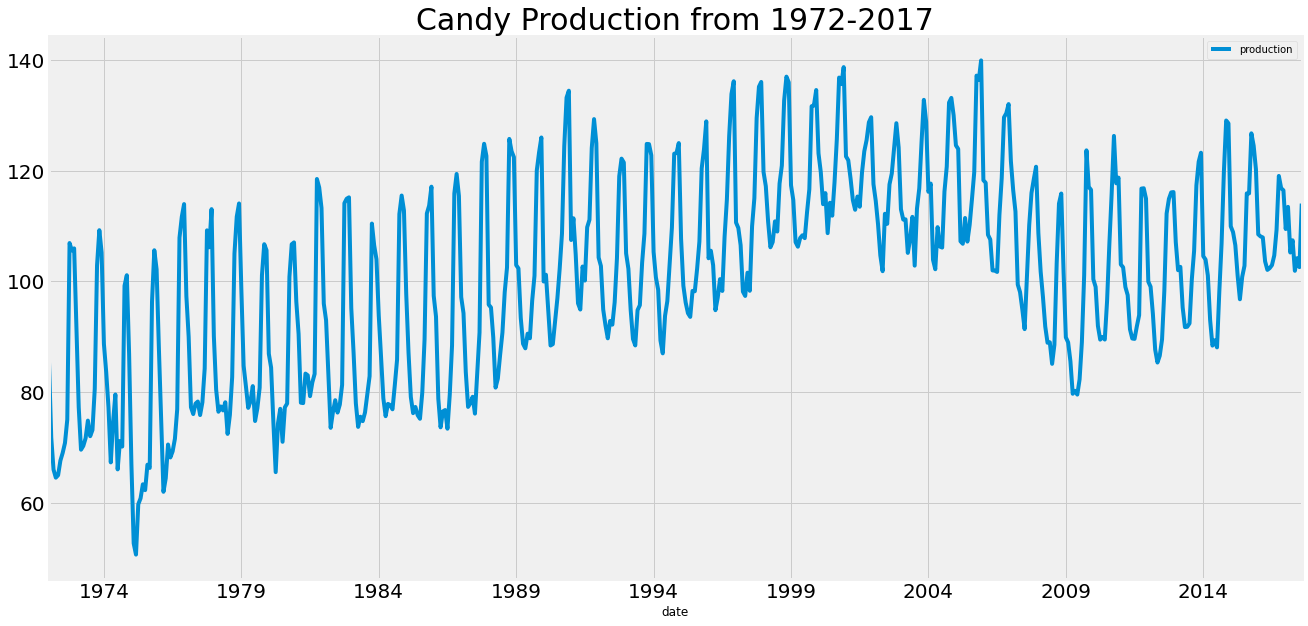

In [8]:
df.plot(figsize=(20, 10), fontsize=20)
plt.title('Candy Production from 1972-2017', fontsize=30)
plt.show()


## Data Exploration 
---
Looking at our time series there is an interesting trend that may be fixed with a square root transform if not for the large dip around 2007-2008. This trend is the result of business cycles and other exongenous variables that effect economic data. We can use a box-cox transformation to remove the trend. Next we can dif the time series to deal with trend and plot both that result, and the resulting ACF and PACF graph that it creates. 

#### Box Cox Transformation
The box cox transformation makes non-normal data normally distributed. We can pass it an argument for lambda to automatically perform a log transform, square root transform, or reciprocal transform. If we pass no argument for lambda it will tune automatically and return a lambda value. 

Lambda Value 1.2550906935610247


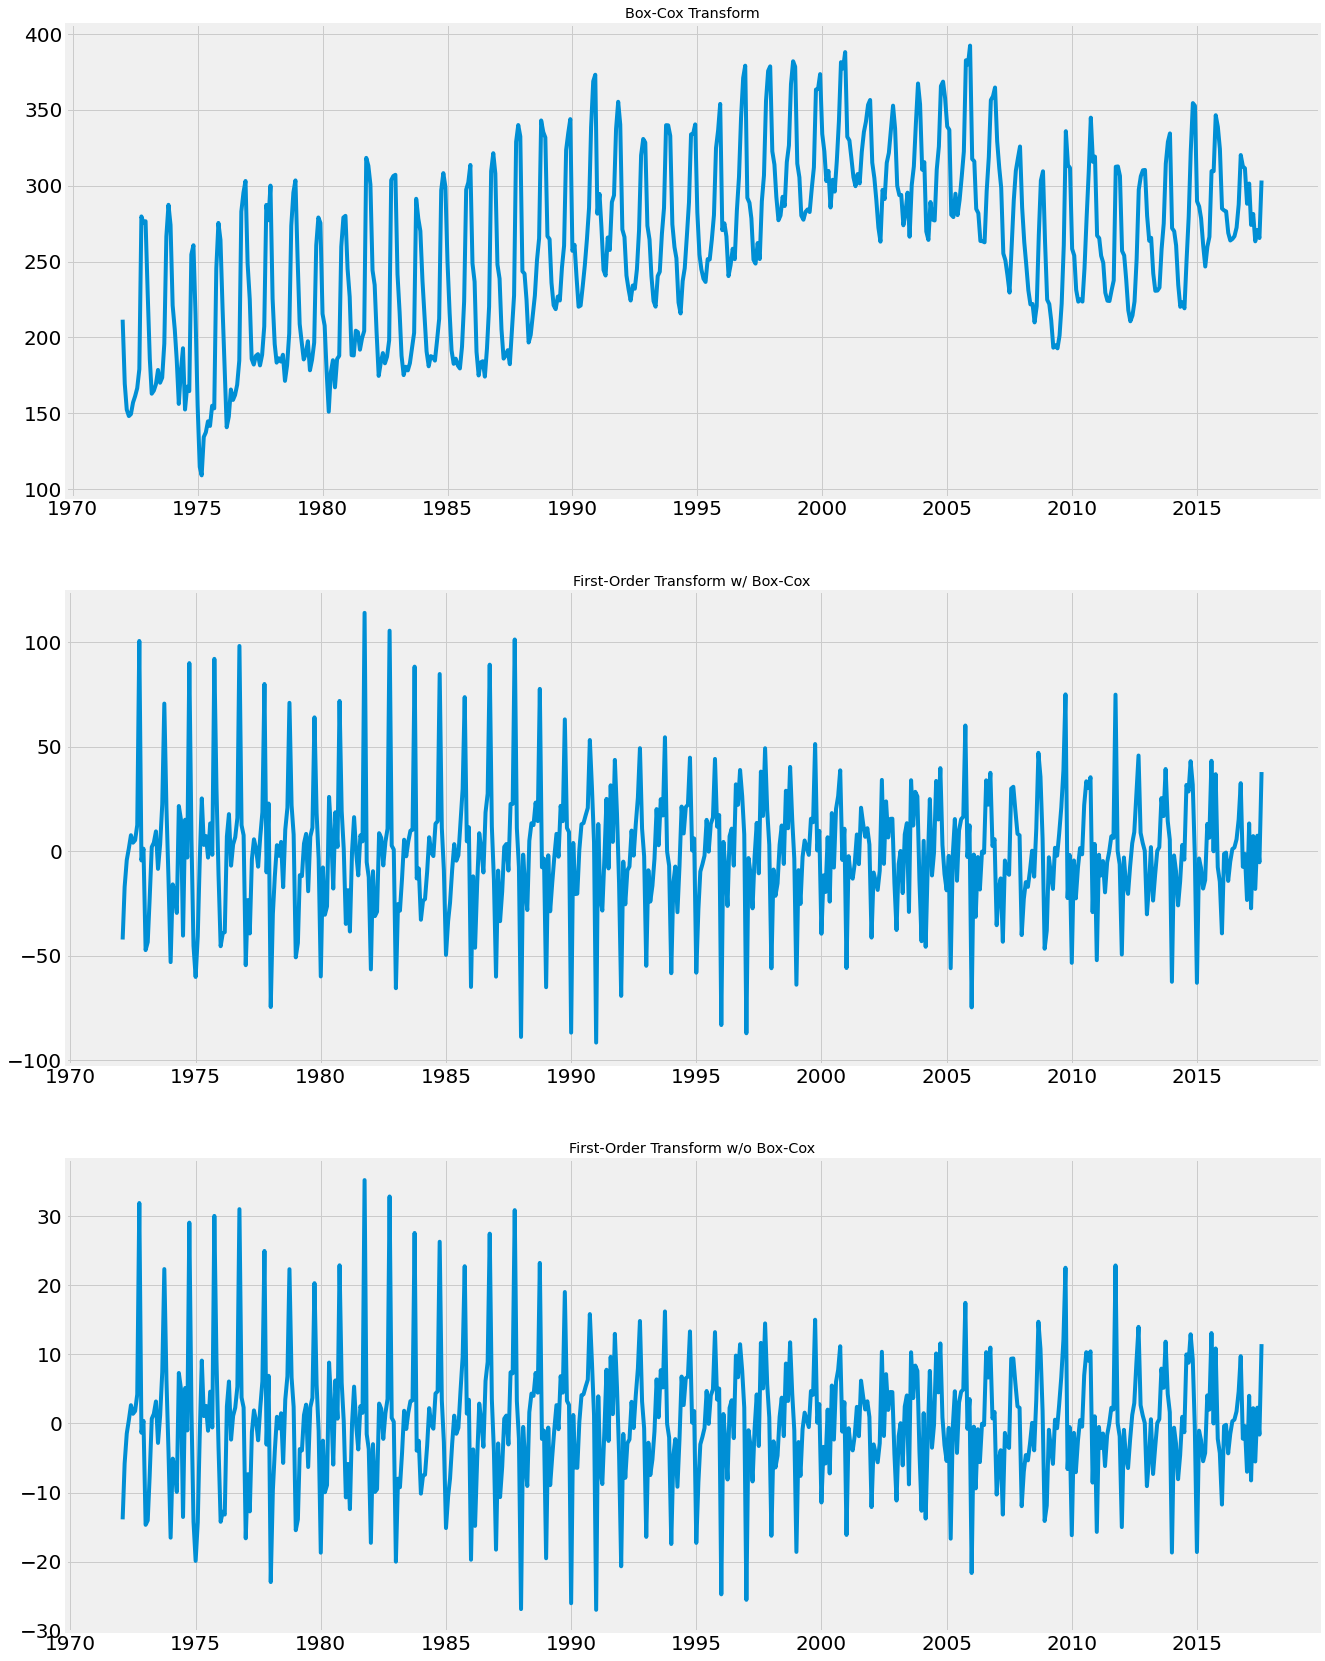

In [9]:
df['bc_production'], lamb = boxcox(df.production)
df['df1_production'] = df['bc_production'].diff()
df['df_production'] = df['production'].diff()
fig = plt.figure(figsize=(20,40))

bc = plt.subplot(411)
bc.plot(df.bc_production)
bc.title.set_text('Box-Cox Transform')
df1 = plt.subplot(412)
df1.plot(df.df1_production)
df1.title.set_text('First-Order Transform w/ Box-Cox')
df2 = plt.subplot(413)
df2.plot(df.df_production)
df2.title.set_text('First-Order Transform w/o Box-Cox')

df.bc_production.dropna(inplace=True)
df.df1_production.dropna(inplace=True)
df.df_production.dropna(inplace=True)

print(f'Lambda Value {lamb}')

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning:




ValueError: On entry to DLASCL parameter number 4 had an illegal value

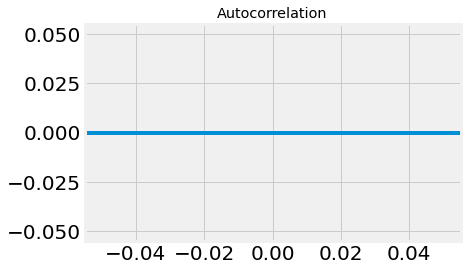

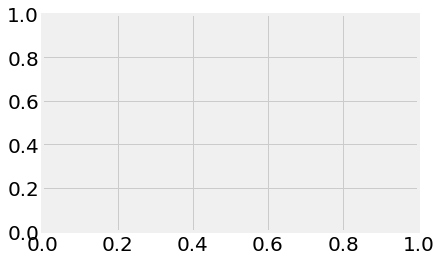

In [10]:
f_acf = plot_acf(df['df_production'], lags=50)
f_pacf = plot_pacf(df['df_production'], lags=50, method='ols')
f_acf.set_figheight(10)
f_acf.set_figwidth(15)
f_pacf.set_figheight(10)
f_pacf.set_figwidth(15)
plt.show()

## Parameter Estimation
---
After the box-cox transformation and differencing we no longer have a trend but the seasonality is still present and irregular. Becuase our lambda value is close to 1 (no transform) and the box-cox transformation didn't appear to make an important difference in the series, I've decided to drop it and the ACF and PACF plots reflect an untransformed series. We can use the ACF and PACF plots to determine the correct parameters for our SARIMA model. 

First, looking at the ACF we have a m value of 12, given that our greatest autocorrelation is at lag number 12, which makes since given our original plot and that this is monthly data. 

Given that m is positive that would indicate that P = 1, and Q = 0. Looking at the ACF and PACF plots both have their first significant lag at 1. So p = 1, and q = 1. Because we differenced the series d will also be 1. So we have parameters of: 
`SARIMA(1,1,1)(1,0,0)[12]`

We will split our data into a training and test set and then fit our SARIMA model.

In [ ]:
split_date = '2008-12-01'
train = df['production'].loc[:split_date]
test = df['production'].loc[split_date:]
train.plot(figsize=(20, 10), fontsize=20)
plt.title('Candy Production Train/Test Split', fontsize=30)
test.plot()
plt.show()

In [ ]:
model = SARIMAX(train, freq='MS', order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))
model_fit = model.fit(disp=False) 

## Model Measurements
---
#### Scale-dependent Errors
Scale dependent errors are errors on the same scale as the data. 
    - Mean Squared Error (MAE): Popular and easy to understand
    - Root Mean Squared Error (RMSE)
    
#### Percentage Errors
Percentage errors are unit free and are frequently used to compare forecast performace between data sets. The percentage erros are typically some form of the estimated_value/ true_value. The downside to percentage errors is that they can lead to infinite or undefined values when the true value is zero. Also, when data is without a meaningful zero, like temperature, the combination of division and then absolute value, like in MAPE, can lead to errors that don't capture the true difference. 
    - Mean absolute percentage error (MAPE)
    - Symmetric MAPE: Deals with MAPE's tendency to put a heavier penalty on negative errors

#### Scaled Errors
Scaled errors are an attempt to get around some of the problems with percentage errors. 
    - Mean absolute scaled error (MASE)

In [ ]:
fcast_len = len(test)
fcast = model_fit.forecast(fcast_len)
mse = mean_squared_error(test, fcast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, fcast)
plt.figure(figsize=(20, 10))
plt.title('Candy Production Forecast', fontsize=30)
plt.plot(train, label='Train')
plt.plot(fcast, label='Forecast')
plt.plot(test, label='Test')

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
plt.legend(fontsize=25)
plt.show()

## Model Evaluation
---
Unfortunately our model is not fitting the trend very well. The problem with the candy forecast data is that it has an unstable trend. What we could do next is decompose the trend from the rest of the time series with a Hodrick-Prescott Filter, a bandpass filter that was created for dealing with business cycles in economic data. 

Instead, we'll use a **rolling forecast**. A rolling forecast is where we forecast one step ahead and then refit our model on the new data, adding data from the test set. It's expensive because the model is refit every timestep but it allows us to forecast where a bad step will add to the overal error without effecting future forecasts. This means that early deviations from the time series because of the trend won't hurt our ability to forecast future steps. 

In [ ]:
def rolling_forecast(train, test, order, season):
    history = [x for x in train]
    model = SARIMAX(history, order= order, seasonal_order= season)
    model_fit = model.fit(disp=False)
    predictions = []
    results = {}
    yhat = model_fit.forecast()[0]

    predictions.append(yhat)
    history.append(test[0])
    for i in range(1, len(test)):
        model = SARIMAX(history, order= order, seasonal_order= season)
        model_fit = model.fit(disp=False)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        obs = test[i]
        history.append(obs)
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    rmse = math.sqrt(mse)
    predictions = pd.Series(predictions, index=test.index)
    results['predictions'] = predictions
    results['mse'] = mse
    results['rmse'] = rmse
    results['mae'] = mae
    return results

In [ ]:
rolling_fcast = rolling_forecast(train, test, (1, 1, 1), (1, 0, 0, 12))

In [ ]:
plt.figure(figsize=(20, 10))
plt.title('Candy Production Rolling Forecast', fontsize=30)
plt.plot(train, label='Train')
plt.plot(rolling_fcast['predictions'], label='Forecast')
plt.plot(test, label='Test')

print(f'Mean Squared Error: {rolling_fcast["mse"]}')
print(f'Root Mean Squared Error: {rolling_fcast["rmse"]}')
print(f'Mean Absolute Error: {rolling_fcast["mae"]}')
plt.legend(fontsize=25)
plt.show()